<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S5_HumanPoseEstimation/EVA4_P2_S5_HumanPoseEstimation_ONNX_Quant_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading human pose estimation and general libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# Load modules/models from EVA course
!rm -rf resnet50
!rm -rf src
!rm -rf *.py
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv /content/Phase2/S5_HumanPoseEstimation/Experiments/* /content/
!mv /content/Phase2/S5_HumanPoseEstimation/src/ /content/
!rm -rf Phase2

!pip install onnx onnxruntime -q

print("Loaded HPE Model and Configuration file")
# from Modules import *
from src import *

     |████████████████████████████████| 7.4MB 3.2MB/s 
     |████████████████████████████████| 4.4MB 49.3MB/s 
Loaded HPE Model and Configuration file


# 2. Load Data, Elon Musk Stage Poses

In [5]:
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/S5/elon_musk.zip
!unzip -q elon_musk
!rm -rf elon_musk.zip

# 3. Load the HPE model, Resnet50 256x256

In [6]:
# Downloading model files
!rm -rf *.tar
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/S5/pose_resnet_50_256x256.pth.tar

In [7]:
CONFIG_FILE = '/content/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
update_config(CONFIG_FILE)
config.GPUS = '' # we are running on CPU
config.TEST.MODEL_FILE = '/content/pose_resnet_50_256x256.pth.tar'

hpe_infer = HPEInference(config)

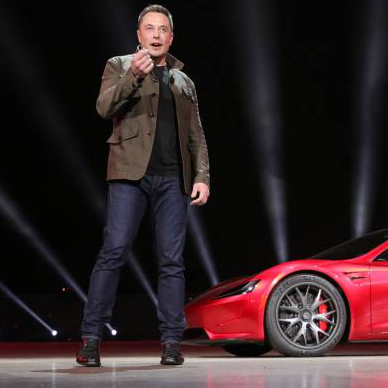

In [9]:
from PIL import Image

IMAGE_FILE = '/content/elon_musk/img6.jpg'
image = Image.open(IMAGE_FILE)
image

#4. Visualize

torch.Size([16, 64, 64])


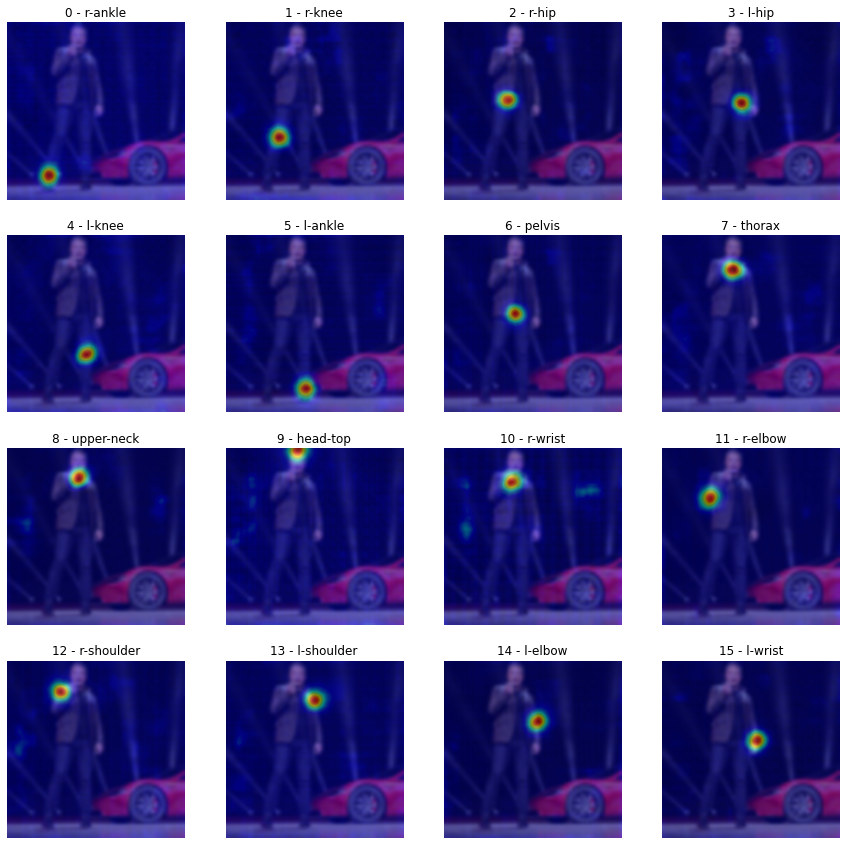

Inference complete in 2166.32ms


In [10]:
hpe_infer.heat_map(image)

Connect the dots and Visualize

torch.Size([16, 64, 64])
Inference complete in 597.00ms


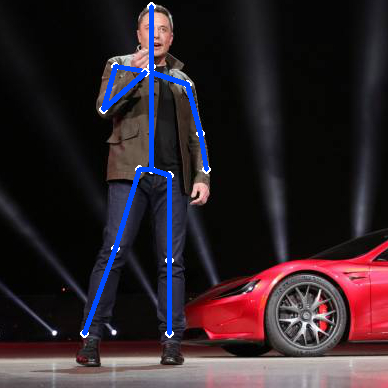

In [11]:
hpe_infer.vis_pose(image,0.4)

# 5. Export ONNX model with and wihtout quantization

In [12]:
hpe_infer.export_onnx_model(model_name="simple_pose_estimation.onnx",quantization=True)

# 6. Inferercing using ONNX Model

In [14]:
hpe_infer_onnx = HPEInference_onnx(model_name="simple_pose_estimation.8bit_quantized.onnx")

(1, 1, 16, 64, 64)
Inference complete in 321.49ms


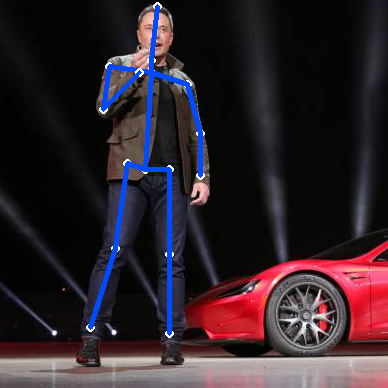

In [15]:
hpe_infer_onnx.vis_pose(image,0.4)